In [3]:
import quimb.tensor as qtn
import quimb as qu
from utils import *

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


The task in this notebook is to find the ground state energy of a given ising model hamiltonian using the update algorithm on tensor networks.
For the update we use the update algorithm implemented in the `quimb` library. But first let's quickly review the basics of the update algorithm.

The imaginary time evolution (ITE) operator is defined as follows:
$$
U(\tau) = e^{-\tau H}
$$
For $\tau \rightarrow \infty$ the ITE operator maps any state to the ground state of the hamiltonian $H$. The ITE operator is not unitary (so, it has actually nothing to do with time evolution), but it works like a softmax (with $\tau = -\beta$) to pick out the ground state.
$$
\ket{\psi_0} \propto \lim_{\tau \rightarrow \infty} U(\tau) \ket{\psi_\text{init}}
$$
To avoid huge numbers in the exponential, we iterate the ITE operator in small steps $\delta \tau$ until convergence.
$$
\psi_{\tau + \delta \tau} = \frac{U(\delta \tau) \psi_{\tau}}{\| U(\delta \tau) \psi_{\tau} \|_2}
$$
Furthermore, the update algorithm uses the fact that a matrix exponential can be decomposed into a product of exponentials of the sum of the matrices if the matrices commute: $e^{A + B} = e^A e^B \iff [A, B] = 0$.
So, if we assume that the hamiltonian can be decomposed into two commuting parts $H = \sum_i H_i$ (e.g. that operate on different parts of the system), we can decompose the ITE operator as follows:
$$
U(\delta \tau) = e^{-\delta \tau H} = e^{-\delta \tau \sum_i H_i} = \prod_i e^{-\delta \tau H_i}
$$

The update algorithm is implemented in the `quimb` library. We can use it to find the ground state energy of a given hamiltonian. Let's try it out on a simple hamiltonian:
$$
H = \sigma^z_1 \sigma^z_2 + \sigma^z_2 \sigma^z_3 + \sigma^z_3 \sigma^z_4
$$
The ground state energy is $E_0 = -3$ and the ground state is $\ket{\psi_0} = \ket{0101}$.

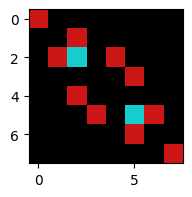

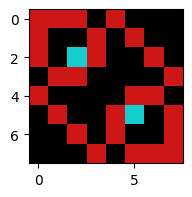

In [4]:
H1 = qu.ham_heis(n=3, j=(1, 1, 1), sparse=False).astype(complex)
H2 = parse_hamiltonian('0.25*(ZZI + IZZ + XXI + IXX + YYI + IYY)')
np.allclose(H1, H2)
imshow(H2, figsize=(2,2))

H1 = qu.ham_heis(n=3, j=(0, 0, 1), b=(-1, 0, 0), sparse=False).astype(complex)
H2 = parse_hamiltonian('0.25*(ZZI + IZZ) + 0.5*(XII + IXI + IIX)')
np.allclose(H1, H2)
imshow(H2, figsize=(2,2))

In [189]:
def ising_model_graph(graph, J=(-1,1), h=(-1,1), g=(-1,1)):
    """ Takes a graph and generates a Hamiltonian string for it that is compatible with `parse_hamiltonian`. """
    if not isinstance(graph, nk.graph.Graph):
        raise ValueError(f"graph must be a nk.graph.Graph, but is {type(graph)}")
    
    # get the number of qubits
    n_qubits = graph.n_nodes
    # get the edges
    edges = graph.edges()
    # get the coupling matrix
    J = np.array(J)
    if J.shape == ():
        # triangular matrix with all couplings set to J
        J = np.triu(np.ones((n_qubits, n_qubits)), k=1) * J
    elif J.shape == (2,):
        # triangular matrix with all couplings set to a random value in this range
        J = np.triu(np.random.uniform(J[0], J[1], (n_qubits, n_qubits)), k=1)
    elif J.shape == (n_qubits, n_qubits):
        # use the given matrix
        pass
    else:
        raise ValueError(f"J must be a scalar, 2-element vector, or matrix of shape {(n_qubits, n_qubits)}, but is {J.shape}")
    
    # get the longitudinal fields
    if h is not None:
        h = np.array(h)
        if h.shape == ():
            h = np.ones(n_qubits) * h
        elif h.shape == (2,):
            h = np.random.uniform(h[0], h[1], n_qubits)
        elif h.shape == (n_qubits,):
            pass
        else:
            raise ValueError(f"h must be a scalar, 2-element vector, or vector of shape {(n_qubits,)}, but is {h.shape}")
        
    # get the transverse fields
    if g is not None:
        g = np.array(g)
        if g.shape == ():
            g = np.ones(n_qubits) * g
        elif g.shape == (2,):
            g = np.random.uniform(g[0], g[1], n_qubits)
        elif g.shape == (n_qubits,):
            pass
        else:
            raise ValueError(f"g must be a scalar, 2-element vector, or vector of shape {(n_qubits,)}, but is {g.shape}")
        
    # generate the Hamiltonian
    H_str = ''
    # pairwise interactions
    for i, j in edges:
        assert i < j, f"edges must be sorted, but ({i}, {j}) is not"
        if J[i,j] != 0:
            H_str += str(J[i,j]) + '*' + 'I'*i + 'Z' + 'I'*(j-i-1) + 'Z' + 'I'*(n_qubits-j-1) + ' + '
    # local longitudinal fields
    if np.any(h):
        H_str += ' + '.join([str(h[i]) + '*' + 'I'*i + 'Z' + 'I'*(n_qubits-i-1) for i in range(n_qubits) if h[i] != 0]) + ' + '
    # local transverse fields
    if np.any(g):
        H_str += ' + '.join([str(g[i]) + '*' + 'I'*i + 'X' + 'I'*(n_qubits-i-1) for i in range(n_qubits) if g[i] != 0]) + ' + '

    # remove trailing ' + '
    H_str = H_str[:-3]

    return H_str

def edges_from_graph(graph, undirected=False):
    edges = graph.edges()
    edges = np.array(edges).T
    if undirected:
        edges = np.concatenate([edges, edges[:,::-1]], axis=0)
    edges = np.unique(edges, axis=0)  # sorts the edges
    return edges[0], edges[1]

def random_ising_own(N: int, graph: nk.graph.Grid):
    """ Generates N random ising models on the given graph. """
    n = graph.n_nodes
    J = np.random.uniform(-1, 1, size=(N, n, n))
    # # make sure each J is symmetric
    # for i in range(N):
    #     J[i] = (J[i] + J[i].T)/2
    #     # make sure the diagonal is zero
    #     J[i] -= np.diag(np.diag(J[i]))
    h = np.random.uniform(-1, 1, size=(N, n))
    g = np.random.uniform(-1, 1, size=(N, n))

    # get the edges for the coupling matrix
    edges = edges_from_graph(graph)

    hamiltonians = []
    for i in range(N):
        H_ising_str = ising_model_graph(graph, J[i], h[i], g[i])

        # create the coupling matrix
        J_i = np.zeros((n, n))
        J_i[edges] = J[i][edges]
        # convert to triu list
        # J_i = J_i[np.triu_indices(n, k=1)]
    
        hamiltonians.append((H_ising_str, graph.extent, {"J": J_i, "h": h[i], "g": g[i]}))

    return hamiltonians

def random_ising_nk(N: int, graph: nk.graph.Grid):
    J = np.random.uniform(-1, 1, size=N) # Coupling constant
    g = np.random.uniform(-1, 1, size=N) # Transverse field
    # J = 10*np.ones(N) # Coupling constant
    # g = -5*np.ones(N) # Transverse field
    n = graph.n_nodes
    edges = edges_from_graph(graph)
    hilbert = nk.hilbert.Spin(s=0.5, N=n)
    h = np.zeros(n)
    n_ones = np.ones(n)

    hamiltonians = []
    for i in range(N):
        ising = nk.operator.Ising(
            hilbert=hilbert,
            graph=graph,
            J=J[i], h=g[i]
        )

        # Convert hyperparameters to the right format
        J_i = np.zeros((n, n))
        J_i[edges] = J[i]
        # convert to triu list
        # J_i = J_i[np.triu_indices(n, k=1)]
    
        hamiltonians.append((ising, graph.extent, {"J": J_i, "h": h, "g": g[i]*n_ones}))
    return hamiltonians

In [233]:
n = (2,3)
graph = nk.graph.Grid(n, pbc=True)

def pos(n):
    x,y = graph.positions[n]
    return int(x), int(y)

H, _, hyp = random_ising_nk(1, graph)[0]
# construct local hamiltonians using qu.ham_heis(2, j=(0, 0, J_ab)) and qu.ham_heis(1, b=(h_a, 0, g_a))
local_two_site_hamiltonians = {}  # dict for qtn.LocalHam2D H2
for a,b in graph.edges():
    J_ab = hyp['J'][a,b]
    local_two_site_hamiltonians[pos(a),pos(b)] = qu.ham_heis(2, j=(0, 0, -J_ab))

local_one_site_hamiltonians = {}  # dict for qtn.LocalHam2D H1
for a in graph.nodes():
    h_a = hyp['h'][a]
    g_a = hyp['g'][a]
    local_one_site_hamiltonians[pos(a)] = qu.ham_heis(1, b=(g_a, 0, h_a))

if type(H) == str:
    ham_full = parse_hamiltonian(H, sparse=True, dtype=float)
else:
    ham_full = H.to_sparse()

# ham_full = qu.ham_heis_2D(*n)
# ham_local = qtn.LocalHam2D(*n, H2=qu.ham_heis(2))

ham_local = qtn.LocalHam2D(*n, H2=local_two_site_hamiltonians, H1=local_one_site_hamiltonians)
# set ordering
ham_local.ordering = 'raster'

energy_exact = qu.groundenergy(ham_full) / (2*np.prod(n))
print(f'Exact ground state energy: {energy_exact:.6f}')

psi0 = qtn.PEPS.rand(*n, bond_dim=4)
su = qtn.SimpleUpdate(
    psi0 = psi0,
    ham = ham_local,
    chi = 8,
    compute_energy_every = None,
    compute_energy_per_site = True,
    keep_best = True,
    progbar = True
)
for tau in [0.3, 0.1, 0.03]:
    su.evolve(50, tau=tau)
print(f'Approximated ground state energy: {su.best["energy"]:.6f}')

# # Continue with Full Update -> this doesn't improve the result at all, but it's really slow
# fu = qtn.FullUpdate(
#     psi0 = su.best['state'].copy(),
#     ham = ham_local,
#     chi = 8,
#     compute_energy_every = None,
#     compute_energy_per_site = True,
#     keep_best = True,
#     progbar = True
# )
# for tau in [0.3, 0.1, 0.03]:
#     fu.evolve(50, tau=tau)
#     print(f'Approximated ground state energy: {fu.best["energy"]:.6f}')

# plt.plot(su.its, su.energies, color='green')
# plt.axhline(energy_exact, color='black')
# plt.title('Simple Update Convergence')
# plt.ylabel('Energy')
# plt.xlabel('Iteration')

su.best

Exact ground state energy: -0.432353


Approximated ground state energy: -0.365414


{'energy': -0.3654143575964271,
 'state': PEPS(tensors=6, indices=13, Lx=2, Ly=3, max_bond=4),
 'it': 150}

This needs way too long